In [78]:
import scipy.io
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

## Modelo masa-resorte

Espacio de estados:

$\dot{x} = Ax + Bu$  
$y = Cx + Du$

$A = 
\begin{bmatrix}
0 & 1 \\
-\frac{k}{m} & -\frac{b}{m}
\end{bmatrix},
$ 
$B =
\begin{bmatrix}
0 \\
\frac{1}{m}
\end{bmatrix},
$ 
$C = I_2$, 
$D = 0$ 

donde $m=1$ es la masa, $k=1$ es la constante del resorte y $b=0$ es el coeficiente de fricción.

### Cargar datos de la simulación

$q$ $\rightarrow$ posición de la masa 

$p$ $\rightarrow$ momento de la masa

In [79]:
data = scipy.io.loadmat('mass_spring.mat')
p = torch.tensor(data['p'], dtype=torch.float32)
q = torch.tensor(data['q'], dtype=torch.float32)
dq_dt = torch.tensor(data['dq'], dtype=torch.float32)
dp_dt = torch.tensor(data['dp'], dtype=torch.float32)
H_true = torch.tensor(data['output'], dtype=torch.float32)
print(p.shape)

torch.Size([50000, 1])


### Gráficas de los datos

#### Trayectoria p vs q

Text(0, 0.5, 'p')

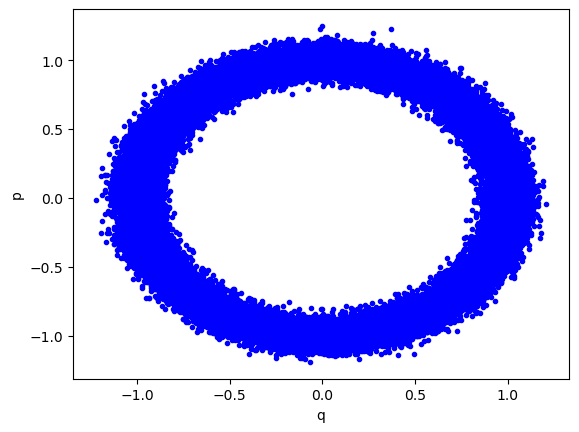

In [80]:
plt.plot(q.detach().numpy(), p.detach().numpy(), '.b')
plt.xlabel('q')
plt.ylabel('p')

#### Derivadas de p y q

Text(0, 0.5, 'dq/dt, dp/dt')

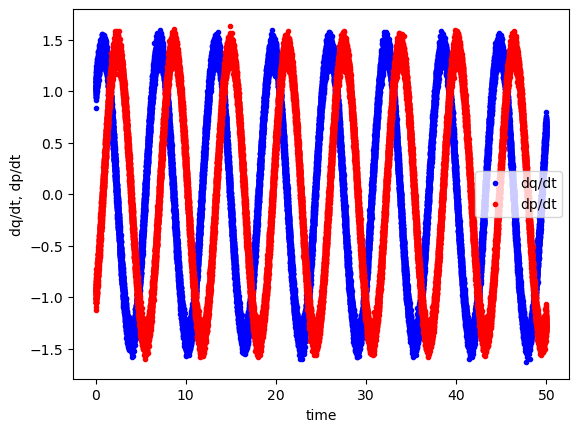

In [81]:
dt = 0.001
time = torch.arange(0, 50, dt)
plt.plot(time, dq_dt.detach().numpy(), '.b', label='dq/dt')
plt.plot(time, dp_dt.detach().numpy(), '.r', label='dp/dt')
plt.legend()
plt.xlabel('time')
plt.ylabel('dq/dt, dp/dt')


### Modelo red neuronal para el sistema masa-resorte

In [82]:
import torch
import torch.nn as nn

class HNN(nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super(HNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.out = nn.Linear(num_hidden, 1)
        
    def forward(self, q, p):
        x = torch.cat([q, p], dim=1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.out(x)
        return x


### Definir función de costo

$L = \|\frac{\partial H}{\partial p} - \frac{\partial q}{\partial t} \|^2 + \| \frac{\partial H}{\partial q} + \frac{\partial p}{\partial t} \|^2 $

In [83]:
def loss_fn(net, q, p, dq_dt, dp_dt):
    q.requires_grad_(True)
    p.requires_grad_(True)
    dp_dt.requires_grad_(True)
    dq_dt.requires_grad_(True)
    H = net(q, p)
    dH_dq, dH_dp = torch.autograd.grad(H, [q, p], grad_outputs=torch.ones_like(H), create_graph=True)
    return torch.mean(torch.norm(dH_dp - dq_dt, dim=1)**2 
                      + torch.norm(dH_dq + dp_dt, dim=1)**2)

In [84]:
# def loss_fn(net, q, p, dq_dt, dp_dt):
#     q.requires_grad_(True)
#     p.requires_grad_(True)
#     dp_dt.requires_grad_(True)
#     dq_dt.requires_grad_(True)
#     H = net(q, p)
#     dH_dq, dH_dp = torch.autograd.grad(H, [q, p], grad_outputs=torch.ones_like(H), create_graph=True)
#     return torch.mean((dH_dp - dq_dt)**2) + torch.mean((dH_dq + dp_dt)**2)

### Entrenar red neuronal
* Optimizador: Adam
* Tasa de aprendizaje: 0.001
* Número de épocas: 1000


In [85]:
num_inputs = 2
num_hidden = 16
lr = 0.01
num_epochs = 200

net = HNN(num_inputs, num_hidden)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

epoch_losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(net, q, p, dq_dt, dp_dt)
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()
    epoch_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss {epoch_loss}")


Epoch 0, loss 2.0641331672668457
Epoch 10, loss 1.51370370388031
Epoch 20, loss 1.0591007471084595
Epoch 30, loss 1.0378742218017578
Epoch 40, loss 1.019317865371704
Epoch 50, loss 1.0109336376190186
Epoch 60, loss 1.010062575340271
Epoch 70, loss 1.009587287902832
Epoch 80, loss 1.0092819929122925
Epoch 90, loss 1.0090667009353638
Epoch 100, loss 1.0089417695999146
Epoch 110, loss 1.008851408958435
Epoch 120, loss 1.0087718963623047
Epoch 130, loss 1.008695363998413
Epoch 140, loss 1.0086244344711304
Epoch 150, loss 1.0085570812225342
Epoch 160, loss 1.0084940195083618
Epoch 170, loss 1.008435606956482
Epoch 180, loss 1.0083822011947632
Epoch 190, loss 1.0083339214324951


### Función de costo vs epochs

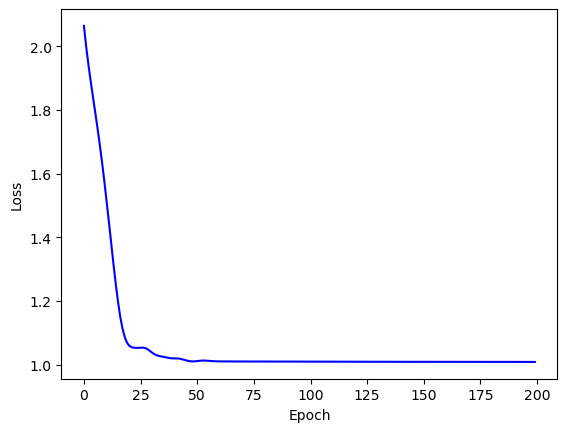

In [86]:
plt.plot(epoch_losses, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Obtener trayectorias con el modelo entrenado

In [87]:
dt = 0.001
T = 10
N = int(T / dt)

trajectory_p, trajectory_q, trajectory_H = [], [], []

p_e = torch.tensor(1.0)
q_e = torch.tensor(0.0)

for k in range(N):
    trajectory_p.append(p_e.item())
    trajectory_q.append(q_e.item())
    with torch.enable_grad():
        q_e.requires_grad_(True)
        p_e.requires_grad_(True)
        H = net(q_e.reshape(1, 1), p_e.reshape(1, 1))
        trajectory_H.append(H.item())
    dH_dq, dH_dp = torch.autograd.grad(H, [q_e, p_e], grad_outputs=torch.ones_like(H), create_graph=True)
    q_e = q_e - dt * dH_dp
    p_e = p_e + dt * dH_dq


### Gráfica de trayectorias

Text(0, 0.5, 'p')

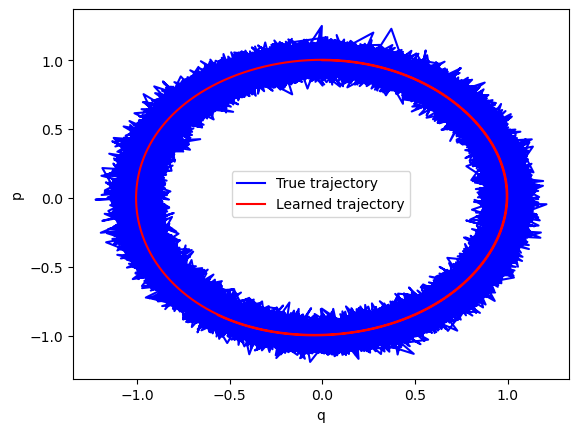

In [88]:
plt.plot(q.detach().numpy(), p.detach().numpy(),'b', label='True trajectory')
plt.plot(trajectory_q, trajectory_p,'r',label='Learned trajectory')
plt.legend()
plt.xlabel('q')
plt.ylabel('p')
